In [1]:
import pandas as pd
import numpy as np

DATASET_PATH = "./summaries_claims.csv"

In [2]:
df = pd.read_csv(DATASET_PATH) 
df = df.dropna()

Let's check how summaries lengths are distributed.

In [3]:
summaries_length = df["summaries"].astype(str).apply(lambda summary: len(summary.split()))
claims_length = df["claims"].astype(str).apply(lambda c: len(c.split()))

summaries_length.describe()

count    26035.000000
mean       980.620588
std       1356.827247
min          7.000000
25%        251.000000
50%        596.000000
75%       1204.000000
max      37845.000000
Name: summaries, dtype: float64

Mean length is $\approx 850$ tokens but maximum and minimum are wildly far apart ($37845$ and $1$ respectively).

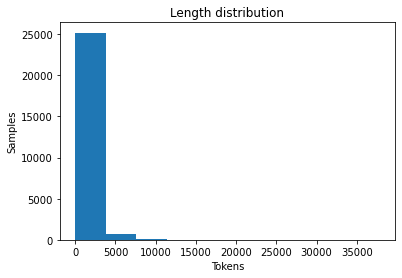

In [4]:
import matplotlib.pyplot as plt
plt.hist(summaries_length)
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()

And indeed summaries longer than $10000$ tokens are exceptionally rare. In fact even summaries with more than $4000$ tokens are uncommon.

In [5]:
sum(summaries_length < 4000) / summaries_length.shape[0]

0.9710005761474938

Summaries whose length is over $4000$ only accounts for $\lt 3\%$ of all the samples.
Let's throw all of those samples with more than $4000$ tokens and see what remaining ones looks like.

count    25280.00000
mean       816.05360
std        785.58842
min          7.00000
25%        243.00000
50%        569.50000
75%       1127.00000
max       3998.00000
Name: summaries, dtype: float64


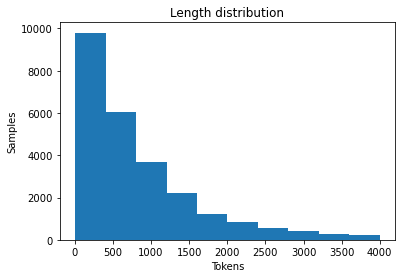

In [6]:
not_outliers = summaries_length < 4000

print(summaries_length[not_outliers].describe())
plt.hist(summaries_length[not_outliers])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

Now the distribution looks more like a Power Law distribution. This is not a problem per-se but might be a problem when we end up training a neural network on that kind of data.

Let's try to see how summaries with less than $500$ tokens are distributed.

count    11489.000000
mean       227.749587
std        143.512320
min          7.000000
25%        100.000000
50%        218.000000
75%        349.000000
max        499.000000
Name: summaries, dtype: float64


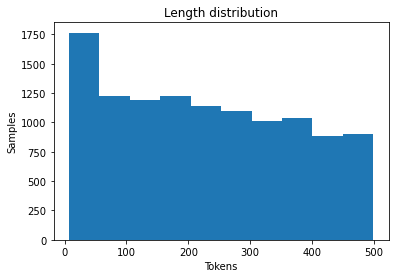

In [7]:
short = summaries_length < 500

print(summaries_length[short].describe())
plt.hist(summaries_length[short])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

The concentratio of summaries with length $\leq 50$ is quite high

count    1532.000000
mean       27.584856
std        11.575159
min         7.000000
25%        18.000000
50%        27.000000
75%        37.000000
max        49.000000
Name: summaries, dtype: float64


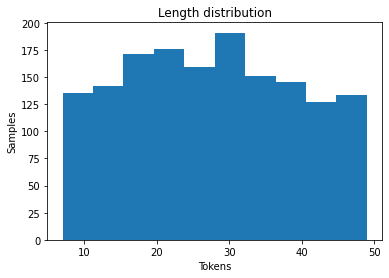

In [8]:
short = summaries_length < 50

print(summaries_length[short].describe())
plt.hist(summaries_length[short])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

Most summaries with length $\leq 50$ ends up having a length $\leq 10$. These are most definetely wrongly parsed documents so let's remove those samples from all the summaries.

We will end up with documents that have summaries length $\in [50, 4000]$.

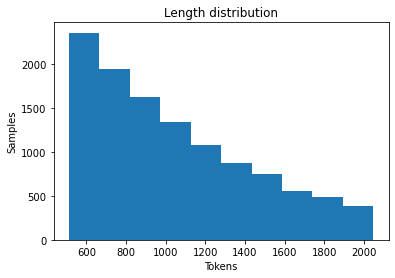

In [9]:
not_outliers = not_outliers & ((summaries_length >= 512) & (summaries_length < 2048))

plt.hist(summaries_length[not_outliers])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

The distribution looks skewed towards shorter documents.

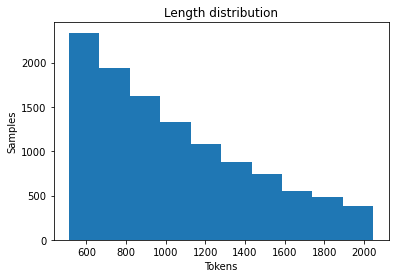

In [10]:
not_outliers = not_outliers & ((claims_length / summaries_length) < 1 )
out = plt.hist(summaries_length[not_outliers])
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

In [13]:
MIN_LENGTH = 512
MAX_LENGTH = 2000
BIN_SIZE = 200
SAMPLES_PER_BIN = 100

balanced_df = pd.DataFrame()

for b in range(512, 2000, 200):
  in_bin = (summaries_length > b) & (summaries_length < b + BIN_SIZE)
  balanced_df = pd.concat([balanced_df, 
                           df[in_bin].sample(n=SAMPLES_PER_BIN)])

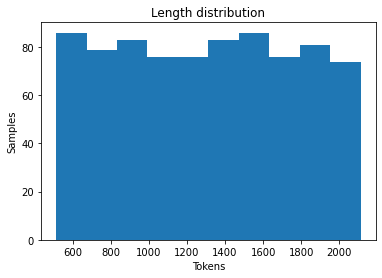

In [14]:
plt.hist(balanced_df["summaries"].astype(str).apply(lambda x: len(x.split())))
plt.title("Length distribution")
plt.xlabel("Tokens")
plt.ylabel("Samples")
plt.show()
plt.show()

In [15]:
balanced_df.to_csv("balanced_csv_naive_small.csv")

In [16]:
balanced_df.shape

(800, 3)